# Part2

### ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks

Article: https://arxiv.org/pdf/1809.00219.pdf

Github: https://github.com/tensorflow/hub/blob/master/examples/colab/image_enhancing.ipynb

To further enhance the visual quality, they thoroughly studied three key components of SRGAN network architecture **[2]**, adversarial loss and perceptual loss, and improve each of them to derive an Enhanced SRGAN (ESRGAN). They introduced the Residual-in-Residual Dense Block (RRDB) without batch normalization as the basic network building unit. Moreover, they borrowed the idea from relativistic GAN **[3]** to let the discriminator predict relative realness instead of the absolute value. We have formulated a novel architecture containing several RDDB blocks without BN layers. So, they have presented an ESRGAN model that achieves consistently better perceptual quality than previous SR methods. In addition, useful techniques including residual scaling and smaller initialization are employed to facilitate the training of the proposed deep model.

#### Application

In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [14]:
! wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

--2021-09-06 23:25:28--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.002s  

2021-09-06 23:25:28 (15.7 MB/s) - ‘original.png’ saved [34146/34146]



In [9]:
# Declaring Constants
IMAGE_PATH = "/Users/esmasert/Desktop/orginal.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [10]:
def preprocess_image(image_path):
    """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
    """
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    # If PNG, remove the alpha channel. The model only supports
    # images with 3 color channels.
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
    """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
    """
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save("%s.jpg" % filename)
    print("Saved as %s.jpg" % filename)

In [11]:
%matplotlib inline
def plot_image(image, title=""):
    """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
    """
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

In [12]:
hr_image = preprocess_image(IMAGE_PATH)

In [13]:
hr_image.shape

TensorShape([1, 120, 124, 3])

Saved as Original Image.jpg


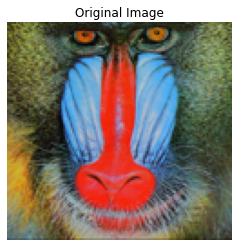

In [15]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [16]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [17]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 6.511203


Saved as Super Resolution.jpg


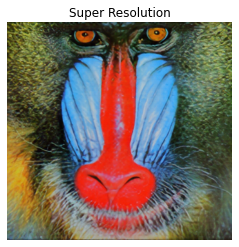

In [18]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [19]:
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "test.jpg"

--2021-09-06 23:27:29--  https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64
Resolving lh4.googleusercontent.com (lh4.googleusercontent.com)... 142.250.187.225
Connecting to lh4.googleusercontent.com (lh4.googleusercontent.com)|142.250.187.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84897 (83K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  82.91K  --.-KB/s    in 0.07s   

2021-09-06 23:27:30 (1.14 MB/s) - ‘test.jpg’ saved [84897/84897]



In [20]:
# Defining helper functions
def downscale_image(image):
    """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
    """
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

    lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

In [28]:
hr_image.shape

TensorShape([1, 512, 512, 3])

In [21]:
hr_image = preprocess_image(IMAGE_PATH)

In [29]:
hr_image.shape

TensorShape([1, 512, 512, 3])

In [22]:
lr_image = downscale_image(tf.squeeze(hr_image))

In [31]:
lr_image.shape

TensorShape([1, 128, 128, 3])

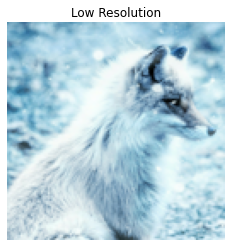

In [23]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [24]:
model = hub.load(SAVED_MODEL_PATH)

In [25]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 3.882812


PSNR Achieved: 28.029171


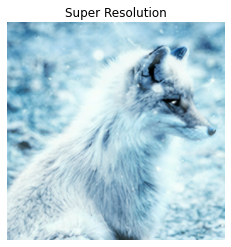

In [26]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 28.029171


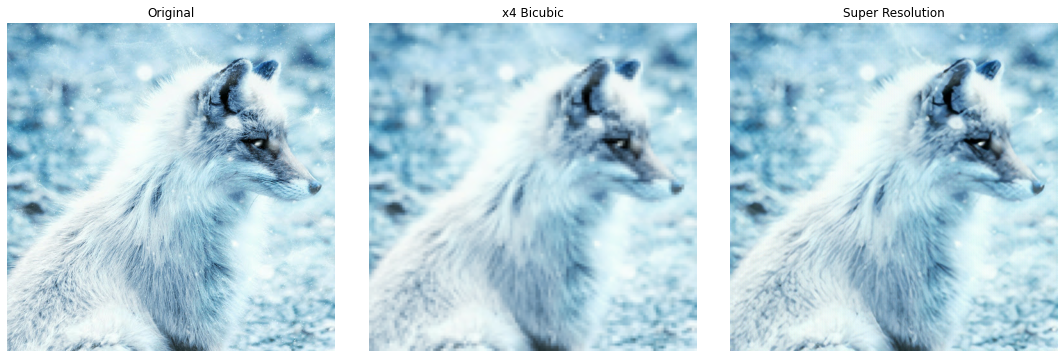

In [27]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [2]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

In [4]:
sample_image = '/Users/esmasert/Desktop/Streama/image1.png'

# read the mask using skimage
imm = imread(sample_image)

In [5]:
imm.shape

(630, 1036, 4)

In [38]:
import cv2
rgb_im = cv2.cvtColor(imm, cv2.COLOR_BGRA2BGR)

In [39]:
rgb_im.shape

(630, 1036, 3)

In [40]:
dsim = downscale_image(tf.squeeze(rgb_im))

In [41]:
dsim.shape

TensorShape([1, 157, 259, 3])

In [42]:
fake_image = model(dsim)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 334.224711


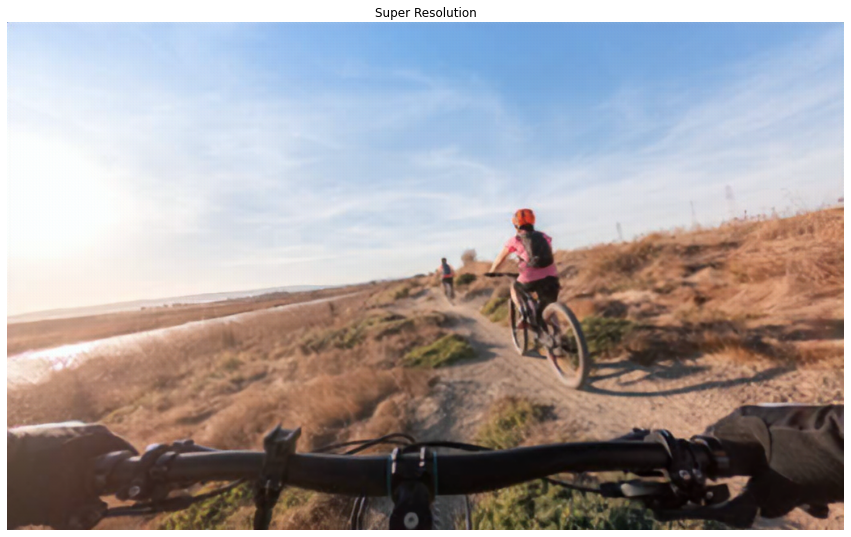

In [44]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")

In [45]:
fake_image.shape

TensorShape([628, 1036, 3])

**Upscaling the image and then predicting with model**

In [82]:
from PIL import Image

# Image.open() can also open other image types
img = Image.open(sample_image)
# WIDTH and HEIGHT are integers
resized_img = img.resize((1500, 800))

In [51]:
resized_img.size

(1500, 800)

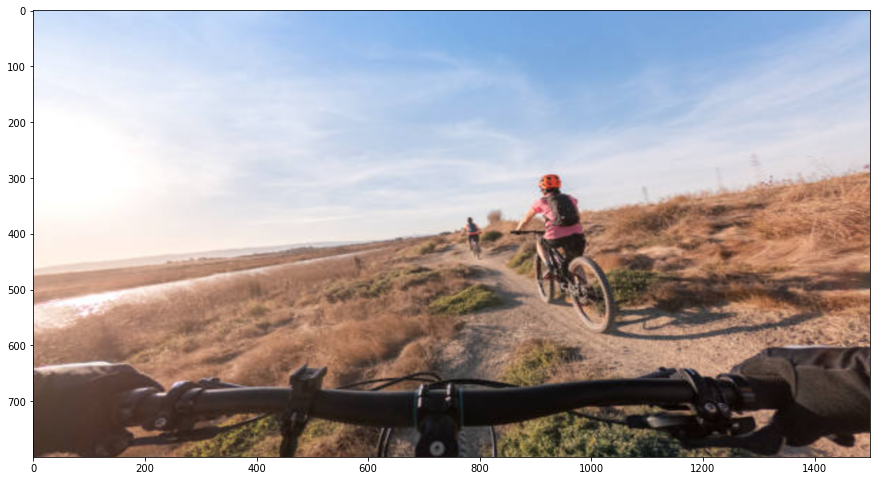

In [52]:
plt.imshow(resized_img)

In [54]:
resized_img_array = np.array(resized_img)

In [55]:
resized_img_array.shape

(800, 1500, 4)

**Converting to RGB from RGBA**

In [66]:
rgb_imBiggerSize = cv2.cvtColor(resized_img_array, cv2.COLOR_BGRA2BGR)

In [67]:
rgb_imBiggerSize.shape

(800, 1500, 3)

In [70]:
dsim = downscale_image(tf.squeeze(rgb_imBiggerSize))

In [71]:
dsim.shape

TensorShape([1, 200, 375, 3])

In [72]:
fake_image = model(dsim)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1350.050696


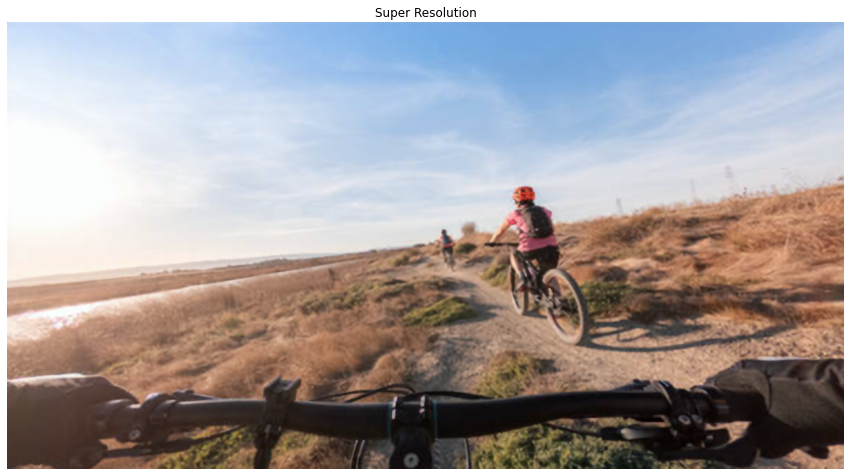

In [73]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")

In [74]:
fake_image.shape

TensorShape([800, 1500, 3])

**Making at least 720p (786 x 1280 pixels)**

In [86]:
img = Image.open(sample_image)
# WIDTH and HEIGHT are integers
width = 1280
height = (width * img.size[1]) // img.size[0]
resized_img = img.resize((width, height))

In [87]:
resized_img.size

(1280, 778)

In [89]:
resized_img_array = np.array(resized_img)

In [91]:
resized_img_array.shape

(778, 1280, 4)

In [93]:
rgb_im720p = cv2.cvtColor(resized_img_array, cv2.COLOR_BGRA2BGR)

In [94]:
rgb_im720p.shape

(778, 1280, 3)

In [96]:
dsim = downscale_image(tf.squeeze(rgb_im720p))

In [97]:
dsim.shape

TensorShape([1, 194, 320, 3])

In [98]:
predictedIm = model(dsim)
predictedIm = tf.squeeze(predictedIm)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 40788.655514


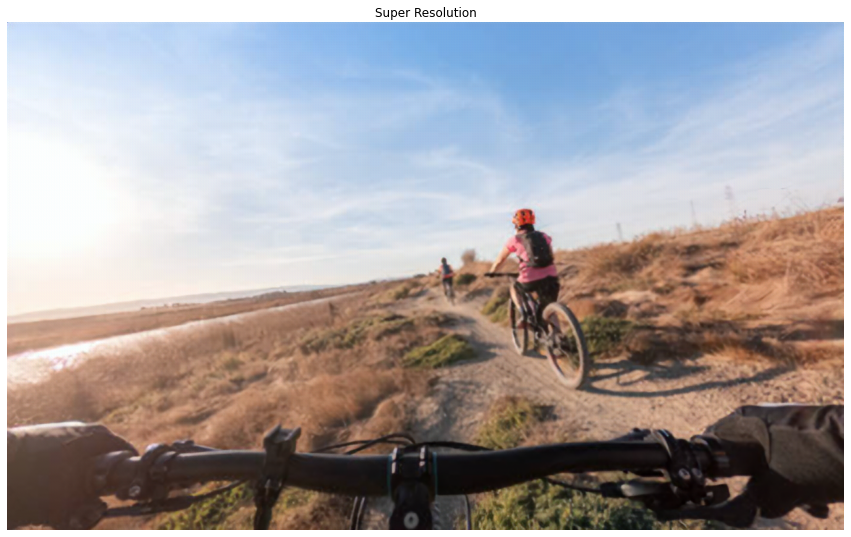

In [99]:
plot_image(tf.squeeze(predictedIm), title="Super Resolution")

In [100]:
predictedIm.shape

TensorShape([776, 1280, 3])

### EDSR: Enhanced Deep Residual Networks for Single Image Super-Resolution

Article: https://arxiv.org/pdf/1707.02921.pdf

Github: https://github.com/Saafke/EDSR_Tensorflow

In this paper, they developed an enhanced deep super-resolution network (EDSR) with performance exceeding those of current state of the art SR methods. The significant performance improvement of their model is due to optimization by removing unnecessary modules in conventional residual networks. The performance is further improved by expanding the model size while we stabilize the training procedure. They also proposed a new multi-scale deep super-resolution system (MDSR) and training method, which can reconstruct high-resolution images of different upscaling factors in a single model. Their proposed single-scale and multi-scale models have
achieved the top ranks in both the standard benchmark
datasets

#### Application

In [7]:
import cv2
from cv2 import dnn_superres

# Create an SR object
sr = dnn_superres.DnnSuperResImpl_create()

# Read image
imageFirst = cv2.imread('/Users/esmasert/Desktop/Streama/image1.png')


In [8]:
imageFirst.shape

(630, 1036, 3)

In [9]:
image = cv2.resize(imageFirst,None,fx=0.5,fy=0.5)
#sr.setInput(image)

In [10]:
image.shape

(315, 518, 3)

In [16]:
"""
For this model, to predict the image I used pre-trained weights and imported model from https://codechina.csdn.net/mirrors/Saafke/EDSR_Tensorflow/-/tree/master/models 
"""
modelPath = "/Users/esmasert/Desktop/FSRCNN_Tensorflow-master/models/models_EDSR_x3.pb"

In [73]:
# Read the desired model
sr.readModel(modelPath)

# Set the desired model and scale to get correct pre- and post-processing
sr.setModel("edsr", 3)

# Upscale the image
result = sr.upsample(image)

# Save the image
cv2.imwrite("/Users/esmasert/Desktop/Streama/upscaled.png", result)

True

In [74]:
result.shape

(945, 1554, 3)

In [144]:
# read the im using skimage
result = imread("/Users/esmasert/Desktop/Streama/upscaled.png")

In [145]:
result.shape

(945, 1554, 3)

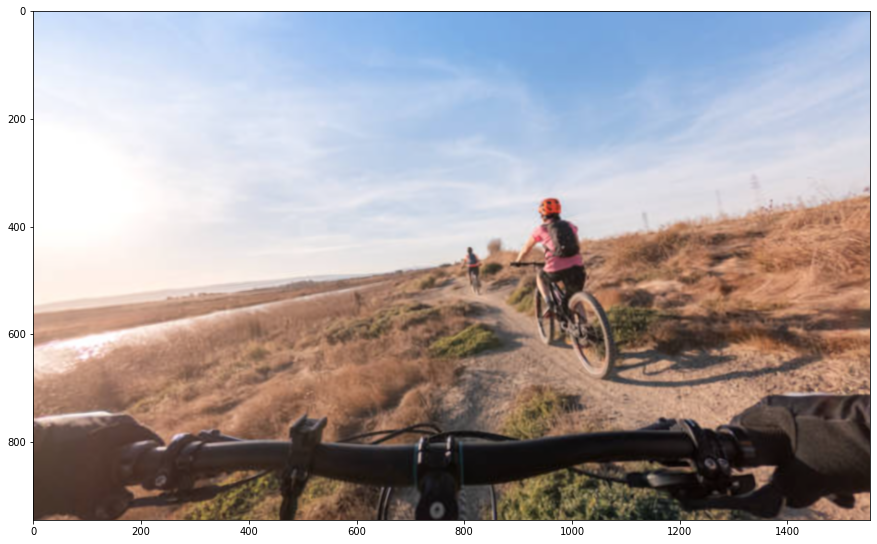

In [146]:
plt.imshow(result)

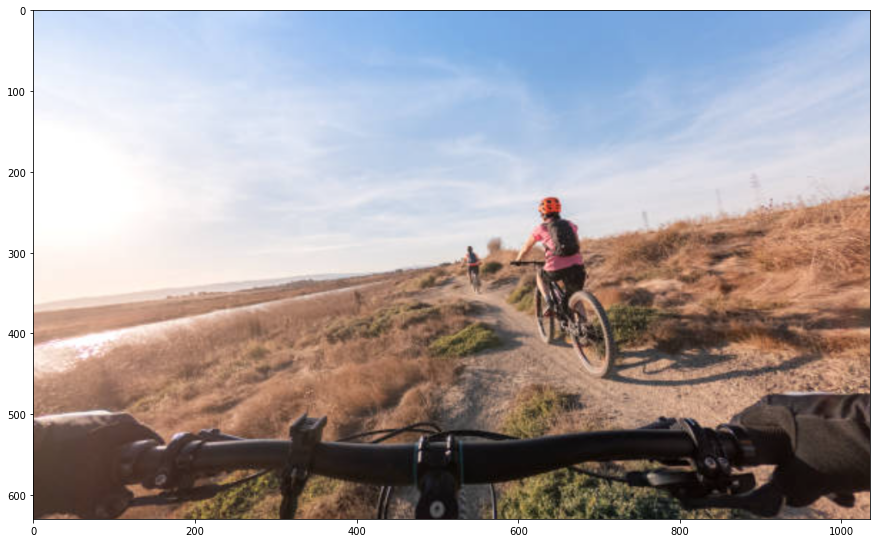

In [147]:
# read the im using skimage
image1 = imread("/Users/esmasert/Desktop/Streama/ss1.png")

plt.imshow(image1)

In [148]:
image1.shape

(630, 1036, 4)

Now to see the results more clearly, let focus on the small areas

In [149]:
import numpy as np

In [150]:
IMG_HEIGHT = 630
IMG_WIDTH = 1036
IMG_CHANNELS = 3

In [151]:
#lstt = numpy.empty(2, dtype=object)
imlist = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
imlist.shape

(2, 630, 1036, 3)

In [152]:
from skimage.transform import resize

resizedResult = resize(result, (630,1036))
resizedResult.shape

(630, 1036, 3)

In [153]:
imlist[0] = imageFirst
imlist[1] = resizedResult

In [154]:
imlist.shape

(2, 630, 1036, 3)

In [155]:
plt.rcParams['figure.figsize'] = [15, 10]

In [156]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

def plot_resultsTestImages(num, img, prefix, title):
    #num is to zoom appropriately
    """Plot the result with zoom-in area."""
    img_array = img.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 3, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 600*num, 700*num, 300*num, 400*num  #(helmet)
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

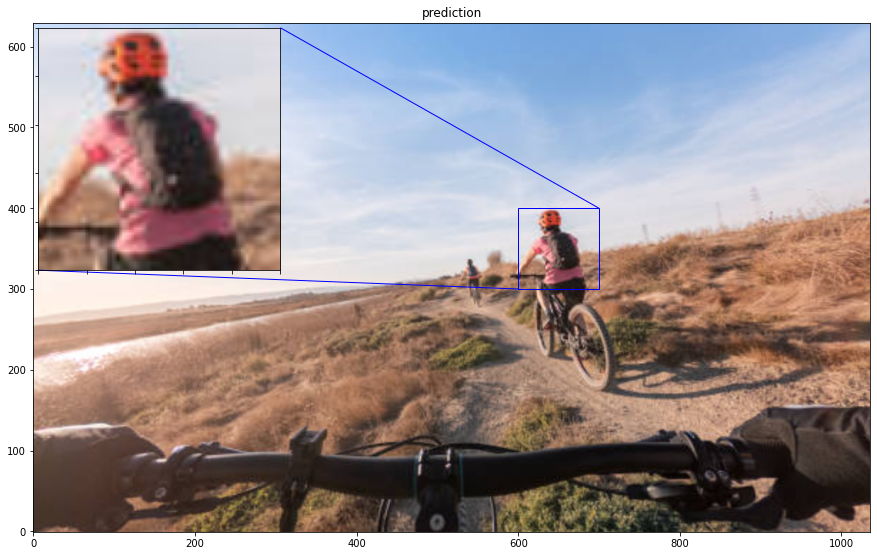

In [157]:
plot_resultsTestImages(1,image1, index, "prediction")

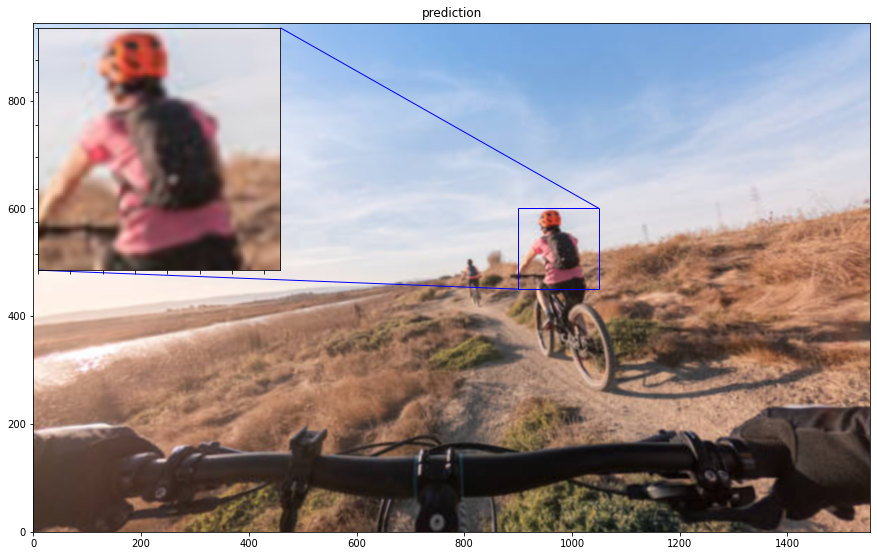

In [158]:
plot_resultsTestImages((1554/1036),result, index, "prediction")

As you can see from the helmet, there is higher resolution in the predicted image.

Shrinking to the original size:

In [184]:
res = cv2.resize(result, dsize=(1036, 630))

In [185]:
res.shape

(630, 1036, 3)

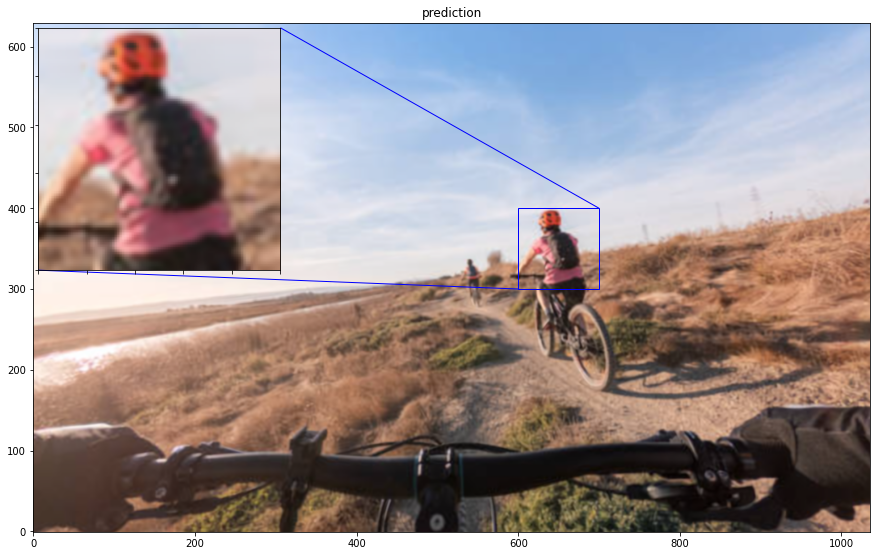

In [186]:
plot_resultsTestImages(1,res, index, "prediction")


# Other Articles, Models and Methods

### FCRNN: Accelerating the Super-Resolution Convolutional Neural Network

Article: http://mmlab.ie.cuhk.edu.hk/projects/FSRCNN.html

In this paper, they aimed at accelerating the current SRCNN and proposed a compact hourglass shape CNN structure for faster and better SR. They re-designed the SRCNN structure mainly in three aspects. First, they introduced a deconvolution layer at the end of the network, then the mapping is learned directly from the original low resolution image (without interpolation) to the high resolution one. Second, they reformulated the mapping layer by shrinking the input feature dimension before mapping and expanding back afterwards. Third, they adopted smaller filter sizes but more mapping layers. The proposed model achieved a speed up of more than 40 times with even superior restoration quality. Further, they presented the parameter settings that can achieve real-time performance on a generic CPU while still maintaining good performance.

### Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network

Article: https://arxiv.org/abs/1609.04802

In this paper, they presented SRGAN, a generative adversarial network (GAN) for image super resolution (SR). They described a deep residual network SRResNet that sets a new state of the art on public benchmark datasets when evaluated with the widely used PSNR measure. They highlighted some limitations of this PSNR focused image super-resolution and introduced SRGAN, which augments the content loss function with an adversarial loss by training a GAN. Using extensive MOS testing, they confirmed that SRGAN reconstructions for large upscaling factors (4×) are, by a considerable margin, more photo-realistic than reconstructions obtained with state-of- the-art reference methods.

### Single Image Super-Resolution Method Using CNN-Based Lightweight Neural Networks

Article: https://www.researchgate.net/publication/348771487_Single_Image_Super-Resolution_Method_Using_CNN-Based_Lightweight_Neural_Networks

In this paper, they proposed two lightweight neural networks with a hybrid residual and dense connection structure to improve the super-resolution performance. They investigated the trade offs between the accuracy of SR (PSNR and SSIM) and the network complexity, such as the number of parameters, memory capacity, and inference speed. Firstly, SR-ILLNN was trained on both low-resolution and high-resolution images. Secondly, SR-SLNN was designed to reduce the network complexity of SR-ILLNN. For training the proposed SR-LNNs, they used the DIV2K image dataset and evaluated both the accuracy of SR and the network complexity on Set5, Set14, BSD100, and Urban100 test image datasets.

### DPED:DSLR-Quality Photos on Mobile Devices with Deep Convolutional Networks

Article: http://people.ee.ethz.ch/~ihnatova/

In this work they presented an end-to-end deep learning approach that bridges this gap by translating ordinary photos into DSLR-quality images. They proposed a photo enhancement solution to effectively transform cameras from common smartphones into high quality DSLR cameras. End-to-end deep learning approach used a composite perceptual error function that combines content, color and texture losses. To train and evaluate our method they introduced DPED, a large-scale dataset that consists of real photos captured from three different phones and one high-end reflex camera, and suggested an efficient way of calibrating the images so that they are suitable for image-to-image learning. Their assessments revealed that the enhanced images demonstrate a quality comparable to DSLR- taken photos, and the method itself can be applied to cameras of various quality levels.

# Conclusion

In conclusion, the quality of image means the details of image’s representation that are stored in pixels. Like; colours, shadows, contrast etc. Thus, by upscaling to higher resolution, we can not add new information to the pixels to improve the quality of image. Because, we actually add more of the existing information already stored in the pixels of original image, through duplicating adjacent or the nearest pixels. So that, no new information will be captured at all. 

To accomplish this situation, deep learning techniques can be used. By training the model, applying it to the image and adding new learned informations to the pixels, the image quality might be improved.

There are massive information about the Image Super Resolution. I tried to apply the Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network, ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks, EDSR: Enhanced Deep Residual Networks for Single Image Super-Resolution. With all the three of them, I could create enhanced photos of the given images. I merged many notebooks to one to gather them in a same notebook. Therefore, order of the code commands might have changed.

There were other papers and methods to be discovered and applied in order to increase the resolution and quality of images. I summarized them, and tried to understand the architectures behind it. However, examining and trying those other information will take more time and effort to explore and implement them properly.

As I realized from researches, many of them use interpolation to create low resolution versions of the images. Then, they train the models with both LR and HR images. However, implementing ‘Bicubic Interpolation' for every images to be trained might result the model may not learn well. I suggest to create the train dataset by both implementing interpolation then creating LR images and having the images of the same objects taken from near and far. So that, information of inter-pixels will not be created from just one type of mathematic representation. I believe this will increase the variation of information extracted from images.

For further works, there might be adjustments within model parameters and implementing different architectures to achieve higher accuracies. Also, trying to merge several train datasets that created from different implementations can be effective for the next models. 


# References

[1] Shi, W., Caballero, J., Huszár, F., Totz, J., Aitken, A.P., Bishop, R., Rueckert, D., & Wang, Z. (2016). Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 1874-1883. 
https://arxiv.org/abs/1609.05158 

[2] Ledig,C.,Theis,L.,Husza ́r,F.,Caballero,J.,Cunningham,A.,Acosta,A.,Aitken, A., Tejani, A., Totz, J., Wang, Z., et al.: Photo-realistic single image super- resolution using a generative adversarial network. In: CVPR.(2017) https://arxiv.org/abs/1609.04802

[3] Jolicoeur-Martineau, A. (2019). The relativistic discriminator: a key element missing from standard GAN. 
https://arxiv.org/abs/1807.00734

[4] Deep Learning based Super Resolution with OpenCV. https://towardsdatascience.com/deep-learning-based-super-resolution-with-opencv-4fd736678066

[5] Chao Dong, Chen Change Loy, Xiaoou Tang. Accelerating the Super-Resolution Convolutional Neural Network, in Proceedings of European Conference on Computer Vision (ECCV). (2016) http://mmlab.ie.cuhk.edu.hk/projects/FSRCNN.html

[6] Lim, B., Son, S., Kim, H., Nah, S., & Lee, K.M. (2017). Enhanced Deep Residual Networks for Single Image Super-Resolution. 2017 IEEE Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), 1132-1140.
https://arxiv.org/pdf/1707.02921.pdf

[7] J. Kim, J. K. Lee, and K. M. Lee. Accurate image super- resolution using very deep convolutional networks. In 2016 IEEE Conference on Computer Vision and Pattern Recog- nition (CVPR), pages 1646–1654, June 2016.

[8] K. Zhang, W. Zuo, Y. Chen, D. Meng, and L. Zhang. Be- yond a gaussian denoiser: Residual learning of deep CNN for image denoising. IEEE Transactions on Image Process- ing, 2017

[9] B. Cai, X. Xu, K. Jia, C. Qing, and D. Tao. Dehazenet: An end-to-end system for single image haze removal. IEEE Transactions on Image Processing, 25(11):5187– 5198, Nov 2016.

[10] Lui, G.; Shih, K.; Wang, T.; Reda, F.; Sapra, K.; Yu, Z.; Tao, A.; Catanzaro, B. Partial convolution based padding. arXiv 2018, arXiv:1811.11718.

[11] Zhang, S.; Fan, Z.; Ling, N.; Jiang, M. Recursive Residual Convolutional Neural Network-Based In-Loop Filtering for Intra Frames. IEEE Trans. Circuits Syst. Video Technol. 2019, 30, 1888–1900.

[12] Cho, S.; Lee, J.; Kim, J.; Kim, Y.; Kim, D.; Chung, J.; Jung, S. Low Bit-rate Image Compression based on Post-processing with Grouped Residual Dense Network. In Proceedings of the Conference on Computer Vision and Pattern Recognition Workshops, Long Beach, CA, USA, 16–20 June 2019.

[13] Ye, Y.; Alshina, E.; Chen, J.; Liu, S.; Pfaff, J.; Wang, S. [DNNVC] AhG on Deep neural networks based video coding, Joint Video Experts Team (JVET) of ITU-T SG 16 WP 3 and ISO/IEC JTC 1/SC29, Document JVET-T0121, Input Document to JVET Teleconference. 2020.